In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
pi = math.pi

#Prints out numbers without "np.flat64" displaying
np.set_printoptions(legacy='1.25')

## Problem 5.1

In [2]:
Zl = complex(1.5,-2)
Zo = complex(1)

Ref = (Zl-Zo)/(Zl+Zo)
print(abs(Ref))

0.6439209162167847


In [3]:
#Calculates B and X in a lumped element matching network.
def L_matching_network(Zo,ZL) :
    ZL_norm = ZL/Zo
    Zo_norm = 1
    ref = (ZL_norm-Zo_norm)/(ZL_norm+Zo_norm)
    print(ref)
    ref_mag = abs(ref)
    RL = ZL.real
    XL = ZL.imag
    if RL<Zo.real :
        print(f'Γ = {round(ref_mag,3)}, Outside 1 + jx circle')
        Xp = np.sqrt(RL*(Zo-RL)) - XL
        Xm = -np.sqrt(RL*(Zo-RL)) - XL
        Bp = np.sqrt((Zo-RL)/RL)/Zo
        Bm = -np.sqrt((Zo-RL)/RL)/Zo
        return [[Xp,Bp],[Xm,Bm]]
    if RL>Zo.real :
        print(f'Γ = {round(ref_mag,3)}, Inside 1 + jx circle')
        Bp = (XL + np.sqrt(RL/Zo)*np.sqrt(RL**2 + XL**2 - Zo*RL))/(RL**2 + XL**2)
        Bm = (XL - np.sqrt(RL/Zo)*np.sqrt(RL**2 + XL**2 - Zo*RL))/(RL**2 + XL**2)
        Xp = (1/Bp) + (XL*Zo)/RL - Zo/(Bp*RL)
        Xm = (1/Bm) + (XL*Zo)/RL - Zo/(Bm*RL)
        return [[Xp,Bp],[Xm,Bm]]
    else :
        print(f'ERROR: RL = Zo')
        return 0

In [4]:
Zl1 = complex(150,-200)
Zo1 = complex(100,0)
L_matching_network(Zo1,Zl1)

(0.5121951219512195-0.39024390243902446j)
Γ = 0.644, Inside 1 + jx circle


[[(177.95130420052192+0j), (0.0010708313008125241+0j)],
 [(-177.95130420052186+0j), (-0.007470831300812524+0j)]]

In [5]:
Zl2 = complex(20,-90)
Zo2 = complex(100,0)
L_matching_network(Zo2,Zl2)

(-0.06666666666666667-0.8j)
Γ = 0.803, Outside 1 + jx circle


[[(130+0j), (0.02+0j)], [(50-0j), (-0.02+0j)]]

## Problem 5.5

### Equations for Lengths of Single Stub Tuning in Series

In [6]:
#Calculates the lengths of stub for two lowest possible single stub in series with load and line.
def calc_single_stub_series(ZL, Zo, type) :
    ''' Inputs:
            ZL: load impedence (must be in complex form!)
            Zo: line impedence to match load to
            type: 'short' or 'open' for load type at end of stub.
        Returns: array of form [[d1,l1],[d2,l2]]
    '''

    Yo = 1/Zo
    YL = 1/ZL
    GL = YL.real
    BL = YL.imag

    if ((type != 'short') & (type != 'open')) : #check if type is valid.
        type1 = 'short'
        type2 = 'open'
        print(f'ERROR: incorrect type. Please choose {type1} or {type2}')
        return -1

    #follows algorithm from 5.2 in D. Pozar - Microwave Engineering, 4th ed (2012).
    #has to possible solutions, t_pos and t_neg, which correspond to a '+' or a '-'
    #   in the t equations.
    if GL != Yo :
        t_pos = (BL + np.sqrt((GL*(((Yo-GL)**2)+ BL**2))/Yo))/(GL-Yo)
        t_neg = (BL - np.sqrt((GL*(((Yo-GL)**2)+ BL**2))/Yo))/(GL-Yo)
    else :
        print('GL = Yo')
        t_pos = -BL/(2*Yo)
        t_neg = 0
    if t_pos >=0 : d_pos = (1/(2*pi))*np.arctan(t_pos)
    else : d_pos = (1/(2*pi))*(pi + np.arctan(t_pos))
    if t_neg >=0 : d_neg = (1/(2*pi))*np.arctan(t_neg)
    else : d_neg = (1/(2*pi))*(pi + np.arctan(t_neg))

    X_pos = ((GL**2)*t_pos - ((Yo-t_pos*BL)*(BL+t_pos*Yo))) / (Yo*(GL**2 + (BL + Yo*t_pos)**2))
    X_neg = ((GL**2)*t_neg - ((Yo-t_neg*BL)*(BL+t_neg*Yo))) / (Yo*(GL**2 + (BL + Yo*t_neg)**2))

    if type == 'short' :
        l_pos = (-1/(2*pi))*np.arctan(X_pos/Zo)
        l_neg = (-1/(2*pi))*np.arctan(X_neg/Zo)
    if type == 'open' :
        l_pos = (1/(2*pi))*np.arctan(Zo/X_pos)
        l_neg = (1/(2*pi))*np.arctan(Zo/X_neg)

    if l_pos < 0 :
        l_pos = l_pos + 0.5
    if l_neg < 0 :
        l_neg = l_neg + 0.5

    return [[d_pos,l_pos],[d_neg,l_neg]]


### Example 5.3

In [7]:
#Example 5.3
ZL = complex(100,80)
Zo = 50
calc_single_stub_series(ZL, Zo, 'open')

[[0.46337321760116423, 0.10236866985856283],
 [0.11974380977679012, 0.39763133014143714]]

### Calculations for Problem

In [8]:
ZL = complex(90,60)
Zo = 75
calc_single_stub_series(ZL, Zo, 'open')

[[0.4813976406943494, 0.14730157322563034],
 [0.17410416488946603, 0.3526984267743697]]

## Problem 5.12

### Equations for Lengths of Single Stub Tuning in Shunt

In [9]:
#Calculates the lengths of stub for two lowest possible single stub shunted with between load and line.
def calc_single_stub_shunt(ZL, Zo, type) :
    ''' Inputs:
            ZL: load impedence (must be in complex form!)
            Zo: line impedence to match load to
            type: 'short' or 'open' for load type at end of stub.
        Returns: array of form [[d1,l1],[d2,l2]]
    '''
    
    Yo = 1/Zo
    RL = ZL.real
    XL = ZL.imag

    if ((type != 'short') & (type != 'open')) : #check if type is valid.
        type1 = 'short'
        type2 = 'open'
        print(f'ERROR: incorrect type. Please choose {type1} or {type2}')
        return -1

    #follows algorithm from 5.2 in D. Pozar - Microwave Engineering, 4th ed (2012).
    #has to possible solutions, t_pos and t_neg, which correspond to a '+' or a '-'
    #   in the t equations.
    if RL != Zo :
        t_pos = (XL + np.sqrt((RL*(((Zo-RL)**2)+ XL**2))/Zo))/(RL-Zo)
        t_neg = (XL - np.sqrt((RL*(((Zo-RL)**2)+ XL**2))/Zo))/(RL-Zo)
    else :
        print('RL = Zo')
        t_pos = -XL/(2*Zo)
        t_neg = 0
    if t_pos >=0 : d_pos = (1/(2*pi))*np.arctan(t_pos)
    else : d_pos = (1/(2*pi))*(pi + np.arctan(t_pos))
    if t_neg >=0 : d_neg = (1/(2*pi))*np.arctan(t_neg)
    else : d_neg = (1/(2*pi))*(pi + np.arctan(t_neg))

    B_pos = ((RL**2)*t_pos - ((Zo-XL*t_pos)*(XL+Zo*t_pos))) / (Zo*(RL**2 + (XL + Zo*t_pos)**2))
    B_neg = ((RL**2)*t_neg - ((Zo-XL*t_neg)*(XL+Zo*t_neg))) / (Zo*(RL**2 + (XL + Zo*t_neg)**2))

    if type == 'open' :
        l_pos = (-1/(2*pi))*np.arctan(B_pos/Yo)
        l_neg = (-1/(2*pi))*np.arctan(B_neg/Yo)
    if type == 'short' :
        l_pos = (1/(2*pi))*np.arctan(Yo/B_pos)
        l_neg = (1/(2*pi))*np.arctan(Yo/B_neg)

    if l_pos < 0 :
        l_pos = l_pos + 0.5
    if l_neg < 0 :
        l_neg = l_neg + 0.5

    return [[d_pos,l_pos],[d_neg,l_neg]]


In [10]:
# Example 5.2
ZL = complex(60,-80)
Zo = 50
calc_single_stub_shunt(ZL, Zo, 'short')

[[0.11042321863830025, 0.0949746216358915],
 [0.2594445306228258, 0.4050253783641085]]

In [11]:
ZL = complex(200,0)
Zo = 100
#ans_series = calc_single_stub_series(ZL, Zo, 'short')
ans_shunt = calc_single_stub_shunt(ZL, Zo, 'short')
print(ans_shunt)
#print(ans_series)

[[0.1520433619923482, 0.15204336199234816], [0.3479566380076518, 0.34795663800765186]]


### Calculations for Plot

In [12]:
Zo = 100 #ohms
ZL = 200 #ohms

input = np.linspace(0.7,1.3,num=300) # vector of f from 0.5 to 2 in over 100 slices
frequency_ratio = [element for element in input] #frequency = x-axis
ref_mag_1 = [999] * len(input)

#Calculate SWR for every f value
index=0
for f in input :
    Bd = ans_shunt[0][0]*2*pi*f
    Bl = ans_shunt[0][1]*2*pi*f
    Zin_d = Zo*((ZL+complex(0,Zo*np.tan(Bd)))/(Zo+complex(0,ZL*np.tan(Bd))))
    Zin_l = complex(0,Zo*np.tan(Bl))
    Zin = Zin_d*Zin_l/(Zin_d+Zin_l)
    ref_mag_1[index] = 20*np.log10(abs((Zin-Zo)/(Zin+Zo))) #reflection coefficient magnitude

    index+=1

ref_mag_2 = [999] * len(input)
index=0
for f in input :
    Bd = ans_shunt[1][0]*2*pi*f
    Bl = ans_shunt[1][1]*2*pi*f
    Zin_d = Zo*((ZL+complex(0,Zo*np.tan(Bd)))/(Zo+complex(0,ZL*np.tan(Bd))))
    Zin_l = complex(0,Zo*np.tan(Bl))
    Zin = Zin_d*Zin_l/(Zin_d+Zin_l)
    ref_mag_2[index] = 20*np.log10(abs((Zin-Zo)/(Zin+Zo))) #reflection coefficient magnitude

    index+=1


### Plotting the Data

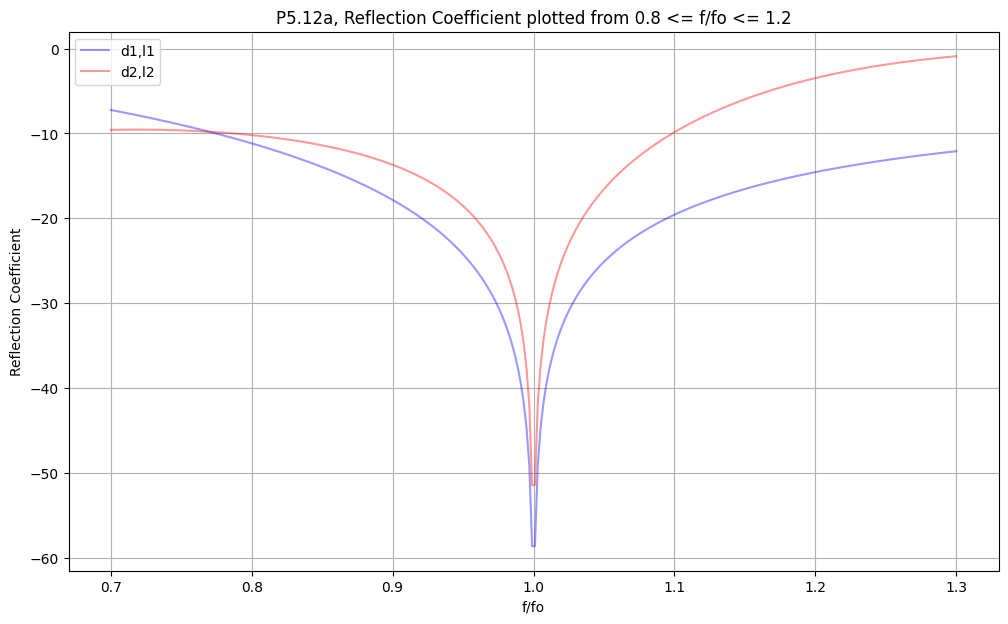

In [13]:
#Plotting the data
fig = plt.figure(figsize = (12,7))

plt.plot(frequency_ratio,ref_mag_1, alpha = 0.4, label='d1,l1', color='blue')
plt.plot(frequency_ratio,ref_mag_2, alpha = 0.4, label='d2,l2', color='red')
plt.title('P5.12a, Reflection Coefficient plotted from 0.8 <= f/fo <= 1.2')
plt.xlabel('f/fo')
plt.ylabel('Reflection Coefficient')
plt.grid()
plt.legend()

## Problem 5.13

### Generic Equations

In [14]:
# Generic Equations

def freq_to_omega(freq) : #get angular frequency (rad/s)
    return 2*pi*freq

def Np_to_dB(Np) : # converts Nepers to Decibels.
    return Np*20/(np.log(10))

#mu_r, epsilon_r = relative properties of medium
#freq = frequency of propagation
def calc_wavenumber(mu_r, epsilon_r, freq) : # wavenumber, k
    return freq_to_omega(freq)*np.sqrt(mu_r*mu_0*epsilon_r*epsilon_0)

# k = wavenumber
def calc_SL_guide_wavelength(k) : # lambda_g
    return 2*pi/k

#frequency = frequency of propagation
#conductance = property of conductor, sigma
def calc_surface_resistance(frequency,conductance) :
    return np.sqrt(freq_to_omega(frequency)*mu_0/(2*conductance))

### Stripline Equations 
(from HW3_EE_5601.ipnyb)

In [15]:
#epsilon_r = relative permitivity of dialectric
#Zo = desired characteristic impedence of line
#d = substrate thickness
def calc_MS_width(epsilon_r, Zo,d) :
    A = (Zo/60)*(np.sqrt((epsilon_r+1)/2)) + ((epsilon_r-1)/(epsilon_r+1))*(0.23 + (0.11)/epsilon_r)
    B = 377*pi/(2*Zo*np.sqrt(epsilon_r))
    #print(f'A = {A}')
    #print(f'B = {B}')
    W = (8*np.exp(A)/(np.exp(2*A)-2))*d
    if (W/d) <= 2 :
        print(f'W/d <= 2')
        return W
    else :
        return ((2/pi)*(B - 1 - np.log(2*B-1) + ((epsilon_r-1)/(2*epsilon_r)) * (np.log(B-1) + 0.39 - (0.61/epsilon_r))))*d
    
#epsilon_r = relative permitivity of dialectric
#W = width of copper microstrip (not groundplane)
#d = substrate thickness
def calc_MS_epsilon_effective(epsilon_r, W, d) :
    return ((epsilon_r+1)/(2) + ((epsilon_r-1)/(2))*(1/(np.sqrt(1 + 12*(d/W)))))

#epsilon_r = relative permitivity of dialectric
#tandelta = property of dialectric
#W = width of copper microstrip (not groundplane)
#d = substrate thickness
def calc_MS_dialectric_loss(epsilon_r,freq, tandelta, W, d) :
    k0 = (2*pi*freq/c)
    epsilon_e = calc_MS_epsilon_effective(epsilon_r, W, d)
    return ((k0*epsilon_r*(epsilon_e-1)*tandelta)/(2*np.sqrt(epsilon_e)*(epsilon_r-1)))

#Rs = surface resistance of conductor
#Zo = characteristic impedence of line.
#W = width of copper microstrip (not groundplane)
def calc_MS_conductor_loss(Rs, Zo, W) : 
    return (Rs/(Zo*W))

#Zo = characteristic impedence of line.
#epsilon_r = relative permitivity of dialectric
#freq = frequency of line.
#d = substrate thickness
#tandelta = property of dialectric
#conductance = conductance of conductor.
def calc_MS_total_loss(Zo, epsilon_r, freq, d, tandelta, conductance) :
    Rs = calc_surface_resistance(freq,conductance)
    W = calc_MS_width(epsilon_r, Zo, d)
    print(f'W = {W}')
    cond_loss = Np_to_dB(calc_MS_conductor_loss(Rs, Zo, W))
    dialectric_loss = Np_to_dB(calc_MS_dialectric_loss(epsilon_r, freq, tandelta, W, d))
    print(f'Conductor Loss = {cond_loss} dB/m')
    print(f'Dialectric Loss = {dialectric_loss} dB/m')
    return cond_loss + dialectric_loss

### Calculations

In [16]:

epsilon_r = 2.2
Zo = 100
ZL = 350
d = 0.00159 #meters
Z1 = np.sqrt(Zo*ZL)

W_line = calc_MS_width(epsilon_r, Zo, d)
W_match = calc_MS_width(epsilon_r, Z1, d)
epsilon_effective = calc_MS_epsilon_effective(epsilon_r,W_match,d)
wavelength = ((3*10**8)/((4*10**9)*np.sqrt(epsilon_effective)))
l = wavelength/4
print(f'Zo = {Zo}, W = {W_line} m')
print(f'Z1 = {Z1}, W = {W_match} m')
print(f'epsilon_effective = {epsilon_effective}')
print(f'wavelength = {wavelength}')
print(f'l = {l}')

W/d <= 2
W/d <= 2
Zo = 100, W = 0.0014250354682354908 m
Z1 = 187.08286933869707, W = 0.00022195753108428243 m
epsilon_effective = 1.6643406605412987
wavelength = 0.05813533129784917
l = 0.014533832824462292
